In [1]:
!pip install efficientnet_pytorch torchtoolbox

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 13.9 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=e91ca2c5ea01a47f4c91ae0cd6d7a1e425be20a885b43bd811727db62ce7af5d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
# importing libraries
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
warnings.simplefilter('ignore')

class MelanomaDataset(Dataset):
    def __init__(self, df, img_path, train, image_transforms):
        self.df = df
        self.img_path = img_path
        self.train = train
        self.transform = image_transforms
        
    def __getitem__(self, index):

        image_path = os.path.join(self.img_path, self.df.iloc[index]['image_name'] + '.jpg')
        x = cv2.imread(image_path)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = cv2.resize(x, (224, 224))
        x = np.array(Image.fromarray(x))
        x = self.transform(x)

        if self.train:
          y = self.df.iloc[index]['target']
          return x, y.astype("float32")
        else:
          return x
    
    def __len__(self):
        return len(self.df)

train_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')

positive_classes = train_df[train_df['target'] == 1]
negative_classes = train_df[train_df['target'] == 0][:len(positive_classes)]
train_df = pd.concat([positive_classes, negative_classes])

X = train_df[['image_name', 'target']]
y = train_df['target']

train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=1999, stratify=y)

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = MelanomaDataset(df=train_df,
                                img_path='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/',
                                train=True,
                                image_transforms = train_transform)
val_dataset = MelanomaDataset(df=valid_df,
                                img_path='/kaggle/input/siim-isic-melanoma-classification/jpeg/train/',
                                train=True,
                                image_transforms = test_transform)
test_dataset = MelanomaDataset(df=test_df,
                               img_path='/kaggle/input/siim-isic-melanoma-classification/jpeg/test/',
                               train=False,
                               image_transforms = test_transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
batch_size = train_loader.batch_size
num_batches = len(train_loader)
total_images = batch_size * num_batches
print("Total number of images in the validation loader:", total_images)

Total number of images in the validation loader: 896


In [4]:
!pip install coremltools==5.0b3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.3/890.3 kB 14.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for coremltools: filename=coremltools-5.0b3-py3-none-any.whl size=1176803 sha256=904a3c7d79dd8b04bd1f6358623997310623fe24d48dc2cc214fbceb989cc794
  Stored in directory: /root/.cache/pip/wheels/69/6e/f9/8b9ba902e61a114ab9148ee9693be6c786b70e8f4b0f43ec52
Successfully built coremltools


In [5]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [6]:
from tqdm import tqdm

scheduler = None
def train(loader, model, criterion, optimizer, scheduler = None):
    loss_epoch = 0
    corrects = 0.0
    num_inputs = 0
    true_labels = []
    predicted_labels = []
    model.train()
    with tqdm(total=len(loader)) as pbar:
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).float()
            true_labels.extend(labels.detach().cpu().numpy())
            predicted_labels.extend(outputs.detach().cpu().numpy()) 
            labels = labels.long()
            loss = criterion(outputs, labels)
            loss_epoch += loss.item()
            num_inputs += inputs.size(0)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

            pbar.update(1)
        return loss / len(train_loader),true_labels, predicted_labels

In [7]:
#author - Ankita Bhatt
import torch
import torchvision.models as models

# Load the Inception-v1 model
model = models.googlenet(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 215MB/s]


In [18]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [19]:
# !pip install lion-pytorch
from lion_pytorch import Lion
optimizer = Lion(model.parameters(),lr=0.002)

In [20]:
print(optimizer)

Lion (
Parameter Group 0
    betas: (0.9, 0.99)
    lr: 0.002
    weight_decay: 0.0
)


In [21]:
inc_tl = []
inc_pl = []
scheduler = None
for epoch in range(20):
    lossacc,inc_tl,inc_pl = train(train_loader,model,criterion,optimizer,scheduler)
    print(lossacc)

100%|██████████| 14/14 [02:07<00:00,  9.08s/it]


tensor(0.0451, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:08<00:00,  9.17s/it]


tensor(0.0456, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:07<00:00,  9.09s/it]


tensor(0.0296, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:09<00:00,  9.22s/it]


tensor(0.0385, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:07<00:00,  9.10s/it]


tensor(0.0305, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:06<00:00,  9.05s/it]


tensor(0.0342, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:06<00:00,  9.03s/it]


tensor(0.0364, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:11<00:00,  9.39s/it]


tensor(0.0385, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:06<00:00,  9.01s/it]


tensor(0.0283, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:09<00:00,  9.26s/it]


tensor(0.0305, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:07<00:00,  9.08s/it]


tensor(0.0272, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:09<00:00,  9.28s/it]


tensor(0.0381, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:09<00:00,  9.23s/it]


tensor(0.0391, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:06<00:00,  9.04s/it]


tensor(0.0394, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:08<00:00,  9.21s/it]


tensor(0.0372, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:09<00:00,  9.27s/it]


tensor(0.0300, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:04<00:00,  8.92s/it]


tensor(0.0283, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:08<00:00,  9.18s/it]


tensor(0.0243, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:08<00:00,  9.20s/it]


tensor(0.0217, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 14/14 [02:10<00:00,  9.30s/it]

tensor(0.0277, device='cuda:0', grad_fn=<DivBackward0>)


In [44]:
print(inc_pl)

[array([-0.00701591,  0.67239606], dtype=float32), array([-0.19286488,  0.6047911 ], dtype=float32), array([-0.10486692, -0.14550956], dtype=float32), array([0.21351376, 0.88331014], dtype=float32), array([-0.31032604,  0.3468498 ], dtype=float32), array([0.2010182 , 0.05753748], dtype=float32), array([-0.17772898, -0.04013244], dtype=float32), array([0.15447819, 0.2672314 ], dtype=float32), array([0.38804042, 0.469842  ], dtype=float32), array([ 0.19351155, -0.03008661], dtype=float32), array([0.28902644, 0.13398165], dtype=float32), array([-0.06589231,  0.42115593], dtype=float32), array([0.04595261, 0.18403313], dtype=float32), array([-0.1386598 ,  0.09533831], dtype=float32), array([-0.13770589,  0.24662033], dtype=float32), array([-0.48687667,  0.20139325], dtype=float32), array([0.36343846, 0.14970244], dtype=float32), array([0.22954717, 0.16280545], dtype=float32), array([-0.2589925 ,  0.35361373], dtype=float32), array([0.35214943, 0.40174007], dtype=float32), array([0.23560908

In [16]:
import torch
print(torch.cuda.is_available())

True


In [12]:
inc_input_labels = []
inc_pred_labels = []
for epoch in range(20):
    lossacc,inc_input_labels,inc_pred_labels = train(val_loader,model,criterion,optimizer,scheduler)
    print(lossacc)

100%|██████████| 1/1 [00:19<00:00, 19.76s/it]


tensor(0.0336, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:16<00:00, 16.58s/it]


tensor(0.0335, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:17<00:00, 17.22s/it]


tensor(0.0325, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:16<00:00, 16.46s/it]


tensor(0.0317, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:16<00:00, 16.89s/it]


tensor(0.0325, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:16<00:00, 16.95s/it]


tensor(0.0311, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:16<00:00, 16.40s/it]


tensor(0.0303, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:17<00:00, 17.05s/it]


tensor(0.0302, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:16<00:00, 16.45s/it]


tensor(0.0288, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:16<00:00, 16.88s/it]


tensor(0.0277, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:16<00:00, 16.49s/it]


tensor(0.0279, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:17<00:00, 17.22s/it]


tensor(0.0269, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:17<00:00, 17.01s/it]


tensor(0.0261, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:16<00:00, 16.53s/it]


tensor(0.0250, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:17<00:00, 17.07s/it]


tensor(0.0237, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:16<00:00, 16.58s/it]


tensor(0.0235, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:17<00:00, 17.26s/it]


tensor(0.0230, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:16<00:00, 16.56s/it]


tensor(0.0223, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:16<00:00, 16.81s/it]


tensor(0.0217, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 1/1 [00:17<00:00, 17.18s/it]


tensor(0.0207, device='cuda:0', grad_fn=<DivBackward0>)


In [13]:
#author - Ankita Bhatt
probabilities = torch.tensor(inc_pred_labels)
predicted_prl = torch.softmax(probabilities, dim=1)
threshold = 0.5  # Set a threshold to determine the binary predicted output
predicted_labels = (predicted_prl[:, 1] > threshold).long()

In [14]:
print(predicted_labels)

tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 0])


In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = accuracy_score(inc_input_labels, predicted_labels)
f1 = f1_score(inc_input_labels, predicted_labels)
precision = precision_score(inc_input_labels, predicted_labels)
recall = recall_score(inc_input_labels,predicted_labels)

print(f'Accuracy: {accuracy} \t F1 Score: {f1} \t Precision: {precision} \t Recall: {recall}')

Accuracy: 0.921875 	 F1 Score: 0.9295774647887325 	 Precision: 0.9041095890410958 	 Recall: 0.9565217391304348


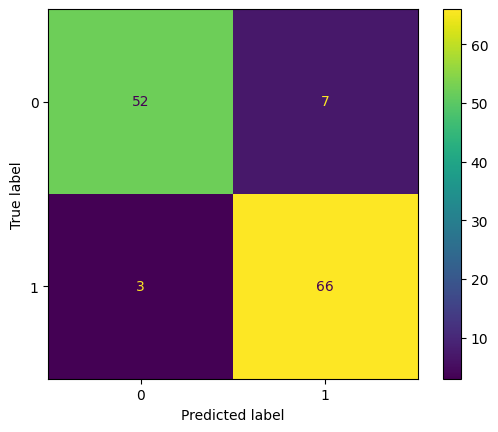

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(inc_input_labels, np.array(predicted_labels) > 0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [17]:
#saving our best confusion matrix
np.savetxt('confusion_matrix.txt', cm, fmt='%d')